In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install -Uqq pandas investpy python-dateutil networkx matplotlib scikit-learn great-expectations seaborn

In [4]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import investpy
from pathlib import Path
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass, field
from datetime import date
from typing import List

In [5]:
%matplotlib inline
pd.set_option('display.max_rows', 500)

In [6]:
# Global variables and constants
COUNTRY = "united states"                   # use investpy.get_stock_countries() to list supported countries
DATASET_FOLDER = "test_data"
TARGET_DATASET_FOLDER = f"{DATASET_FOLDER}/{COUNTRY}"
STOCKS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks.csv"
STOCKS_INFO_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_info.csv"
STOCKS_FINANCE_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_finance.csv"
STOCKS_DIVIDENDS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_dividends.csv"
STOCKS_SELECTED = f"{TARGET_DATASET_FOLDER}/stocks_selected.csv"

In [7]:
def create_folder(folder):
    """Create folder if not exists"""
    if not os.path.exists(folder):
        os.makedirs(folder)

# Create target folder
create_folder(TARGET_DATASET_FOLDER)

In [8]:
# Get stocks for the country
df_stocks = investpy.get_stocks(country=COUNTRY)
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4582 entries, 0 to 4581
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    4582 non-null   object
 1   name       4582 non-null   object
 2   full_name  4582 non-null   object
 3   isin       4582 non-null   object
 4   currency   4582 non-null   object
 5   symbol     4582 non-null   object
dtypes: object(6)
memory usage: 214.9+ KB


In [9]:
display(len(df_stocks))
display(df_stocks.head(10))

4582

,country,name,full_name,isin,currency,symbol
0,united states,Boeing,Boeing Co,US0970231058,USD,BA
1,united states,General Motors,General Motors Company,US37045V1008,USD,GM
2,united states,Chevron,Chevron Corp,US1667641005,USD,CVX
3,united states,Citigroup,Citigroup Inc,US1729674242,USD,C
4,united states,Bank of America,Bank of America Corp,US0605051046,USD,BAC
5,united states,AT&T,AT&T Inc,US00206R1023,USD,T
6,united states,Caterpillar,Caterpillar Inc,US1491231015,USD,CAT
7,united states,Intel,Intel Corporation,US4581401001,USD,INTC
8,united states,Microsoft,Microsoft Corporation,US5949181045,USD,MSFT
9,united states,Alcoa,Alcoa Corp,US0138721065,USD,AA


In [10]:
def save_csv(df, file_name):
    df.to_csv(file_name, header=True, index=False)

# Save stock list
save_csv(df_stocks, STOCKS_DATASET)

In [11]:
def get_stock_info(symbol, country):
    try:
        return investpy.get_stock_information(symbol, country)
    except:
        return None
    
def get_stock_dividends(symbol, country):
    try:
        return investpy.get_stock_dividends(symbol, country)
    except:
        return None
    
def read_csv(file):
    if not os.path.isfile(file):
        return None
    return pd.read_csv(file)

def download_stocks_info(df):
    df_stocks_info = None
    count = 0
    for _, row in df.iterrows():
        count = count + 1
        # print(f"{count}/{len(df)}: {row.symbol}-{row['name']}")
        df_stock = get_stock_info(row.symbol, row.country)
        if df_stock is None:
            continue
        if df_stocks_info is None:
            df_stocks_info  = df_stock
        else:
            df_stocks_info = df_stocks_info.append(df_stock)
        if count % 10 == 0:
            print(f"Saving {count}/{len(df)}")
            save_csv(df_stocks_info, STOCKS_INFO_DATASET)
            time.sleep(3)
    save_csv(df_stocks_info, STOCKS_INFO_DATASET)

def download_stocks_dividends(df):
    df_stocks_dividends = None
    count = 0
    for _, row in df.iterrows():
            count = count + 1
            #print(f"{count}/{len(df)}: {row.symbol}-{row['name']}")
            df_stock = get_stock_dividends(row.symbol, row.country)
            if df_stock is None:
                continue
            df_stock['Symbol'] = row.symbol
            if df_stocks_dividends is None:
                df_stocks_dividends  = df_stock
            else:
                df_stocks_dividends = df_stocks_dividends.append(df_stock)
            if count % 10 == 0:
                print(f"Saving {count}/{len(df)}")
                save_csv(df_stocks_dividends, STOCKS_DIVIDENDS_DATASET)
                time.sleep(3)
    save_csv(df_stocks_dividends, STOCKS_DIVIDENDS_DATASET)

In [12]:
#download_stocks_info(df_stocks)

#download_stocks_dividends(df_stocks)

In [13]:
df_stocks_info = read_csv(STOCKS_INFO_DATASET)
display(df_stocks_info.head(10))

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date
0,BA,220.83,217.46-221.18,62160000000.0,219.45,141.58-278.57,-15.35,6336674.0,127880000000.0,N/A(N/A),10924103.0,-,1.61,29.27%,586151904.0,27/10/2021
1,GM,48.95,48.42-48.99,139640000000.0,48.8,28.24-64.3,8.65,9857370.0,70870000000.0,N/A(N/A),16140363.0,5.65,1.3,65.6%,1451723812.0,27/10/2021
2,CVX,97.71,97.38-98.43,116310000000.0,97.4,65.16-113.11,1.86,9004216.0,188540000000.0,5.36(5.49%),9921064.0,52.34,1.3,18.49%,1933911944.0,29/10/2021
3,C,71.5,70.65-71.73,41430000000.0,71.62,40.49-80.29,9.63,13645145.0,144250000000.0,2.04(2.85%),19743259.0,7.39,1.91,38.19%,2026785183.0,14/10/2021
4,BAC,41.02,40.68-41.19,46640000000.0,41.02,22.95-43.49,2.99,41758807.0,345430000000.0,0.84(2.05%),46868294.0,13.74,1.56,59.98%,8414903881.0,14/10/2021
5,T,27.64,27.32-27.75,176020000000.0,27.64,26.35-33.88,-0.31,26938723.0,196770000000.0,2.08(7.53%),31822765.0,-,0.74,-6.86%,7139856703.0,21/10/2021
6,CAT,211.78,210-212.8,45890000000.0,211.15,142.73-246.69,7.83,2508364.0,115170000000.0,4.44(2.10%),3776196.0,26.88,0.9,43.34%,547471467.0,28/10/2021
7,INTC,53.73,53.32-54.08,77620000000.0,53.44,43.61-68.48,4.5,13276862.0,217090000000.0,1.39(2.59%),21726424.0,11.95,0.6,6.19%,4057000000.0,28/10/2021
8,MSFT,301.15,300.26-302.6,168090000000.0,300.99,196.25-305.84,8.06,14353744.0,2260000000000.0,2.24(0.74%),22272498.0,37.39,0.78,38.58%,7514891248.0,27/10/2021
9,AA,46.91,46.04-47.72,10460000000.0,46.96,10.98-48.24,2.27,5182407.0,8820000000.0,N/A(N/A),7766780.0,20.82,2.7,231.76%,186866156.0,20/10/2021


In [14]:
# Convert PE ratio
df_stocks_info['PE'] = df_stocks_info['P/E Ratio'].apply(lambda x: float(x.replace('%','').replace('-','0')))
#df_stocks_info['Next Earning'] = pd.to_datetime(df_stocks_info['Next Earnings Date'], format='%d/%m/%Y', errors='ignore')
display(df_stocks_info.head(10))
df_stocks_info.info()

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE
0,BA,220.83,217.46-221.18,62160000000.0,219.45,141.58-278.57,-15.35,6336674.0,127880000000.0,N/A(N/A),10924103.0,-,1.61,29.27%,586151904.0,27/10/2021,0.00
1,GM,48.95,48.42-48.99,139640000000.0,48.8,28.24-64.3,8.65,9857370.0,70870000000.0,N/A(N/A),16140363.0,5.65,1.3,65.6%,1451723812.0,27/10/2021,5.65
2,CVX,97.71,97.38-98.43,116310000000.0,97.4,65.16-113.11,1.86,9004216.0,188540000000.0,5.36(5.49%),9921064.0,52.34,1.3,18.49%,1933911944.0,29/10/2021,52.34
3,C,71.5,70.65-71.73,41430000000.0,71.62,40.49-80.29,9.63,13645145.0,144250000000.0,2.04(2.85%),19743259.0,7.39,1.91,38.19%,2026785183.0,14/10/2021,7.39
4,BAC,41.02,40.68-41.19,46640000000.0,41.02,22.95-43.49,2.99,41758807.0,345430000000.0,0.84(2.05%),46868294.0,13.74,1.56,59.98%,8414903881.0,14/10/2021,13.74
5,T,27.64,27.32-27.75,176020000000.0,27.64,26.35-33.88,-0.31,26938723.0,196770000000.0,2.08(7.53%),31822765.0,-,0.74,-6.86%,7139856703.0,21/10/2021,0.00
6,CAT,211.78,210-212.8,45890000000.0,211.15,142.73-246.69,7.83,2508364.0,115170000000.0,4.44(2.10%),3776196.0,26.88,0.9,43.34%,547471467.0,28/10/2021,26.88
7,INTC,53.73,53.32-54.08,77620000000.0,53.44,43.61-68.48,4.5,13276862.0,217090000000.0,1.39(2.59%),21726424.0,11.95,0.6,6.19%,4057000000.0,28/10/2021,11.95
8,MSFT,301.15,300.26-302.6,168090000000.0,300.99,196.25-305.84,8.06,14353744.0,2260000000000.0,2.24(0.74%),22272498.0,37.39,0.78,38.58%,7514891248.0,27/10/2021,37.39
9,AA,46.91,46.04-47.72,10460000000.0,46.96,10.98-48.24,2.27,5182407.0,8820000000.0,N/A(N/A),7766780.0,20.82,2.7,231.76%,186866156.0,20/10/2021,20.82


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4574 entries, 0 to 4573
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Stock Symbol        4574 non-null   object 
 1   Prev. Close         4574 non-null   object 
 2   Todays Range        4574 non-null   object 
 3   Revenue             4574 non-null   object 
 4   Open                4574 non-null   object 
 5   52 wk Range         4574 non-null   object 
 6   EPS                 4574 non-null   object 
 7   Volume              4574 non-null   float64
 8   Market Cap          4574 non-null   object 
 9   Dividend (Yield)    4574 non-null   object 
 10  Average Vol. (3m)   4574 non-null   object 
 11  P/E Ratio           4574 non-null   object 
 12  Beta                4574 non-null   object 
 13  1-Year Change       4574 non-null   object 
 14  Shares Outstanding  4574 non-null   object 
 15  Next Earnings Date  4574 non-null   object 
 16  PE    

In [15]:
df_stocks_dividends = read_csv(STOCKS_DIVIDENDS_DATASET)
# display(df_stocks_dividends.head(10))

df_stocks_dividends['Year'] = df_stocks_dividends['Date'].apply(lambda x: int(x[0:4]))
df_stocks_dividends['Yield'] = df_stocks_dividends['Yield'].apply(lambda x: float(x.replace('%','').replace('-','0').replace(",","")))

display(df_stocks_dividends[df_stocks_dividends['Symbol'] =='GM'].head(20))
df_stocks_dividends.info()

,Date,Dividend,Type,Payment Date,Yield,Symbol,Year
77,2020-03-05,0.38,quarterly,2020-03-20,7.06,GM,2020
78,2019-12-05,0.38,quarterly,2019-12-19,4.55,GM,2019
79,2019-06-06,0.38,quarterly,2019-06-21,3.74,GM,2019
80,2019-03-07,0.38,quarterly,2019-03-22,3.89,GM,2019
81,2018-12-06,0.38,quarterly,2018-12-20,3.92,GM,2018
82,2018-09-06,0.38,quarterly,2018-09-21,4.97,GM,2018
83,2018-06-07,0.38,quarterly,2018-06-22,3.87,GM,2018
84,2018-03-08,0.38,quarterly,2018-03-23,4.03,GM,2018
85,2017-12-07,0.38,quarterly,2017-12-21,3.58,GM,2017
86,2017-09-07,0.38,quarterly,2017-09-22,3.35,GM,2017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115664 entries, 0 to 115663
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          115664 non-null  object 
 1   Dividend      115664 non-null  float64
 2   Type          115664 non-null  object 
 3   Payment Date  115292 non-null  object 
 4   Yield         115664 non-null  float64
 5   Symbol        115664 non-null  object 
 6   Year          115664 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 6.2+ MB


In [16]:
# Average 2 years yield
df_dividends_summary = df_stocks_dividends[ df_stocks_dividends['Year'].isin([2021,2020]) ][['Symbol','Yield']]

df_dividends_summary = df_dividends_summary.groupby(['Symbol']).sum()
df_dividends_summary['Yield'] = df_dividends_summary['Yield'] / 2   # Average over 2 years
# df_dividends_summary = df_dividends_summary.groupby(['Symbol']).mean()

df_dividends_summary.reset_index(inplace=True)

#display(df_dividends_summary.head(20))

In [17]:
df_summary = pd.merge(df_stocks_info, df_dividends_summary, how='left', left_on=['Stock Symbol'], right_on=['Symbol'])
display(df_summary.head(10))

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE,Symbol,Yield
0,BA,220.83,217.46-221.18,62160000000.0,219.45,141.58-278.57,-15.35,6336674.0,127880000000.0,N/A(N/A),10924103.0,-,1.61,29.27%,586151904.0,27/10/2021,0.00,NaN,NaN
1,GM,48.95,48.42-48.99,139640000000.0,48.8,28.24-64.3,8.65,9857370.0,70870000000.0,N/A(N/A),16140363.0,5.65,1.3,65.6%,1451723812.0,27/10/2021,5.65,GM,3.530
2,CVX,97.71,97.38-98.43,116310000000.0,97.4,65.16-113.11,1.86,9004216.0,188540000000.0,5.36(5.49%),9921064.0,52.34,1.3,18.49%,1933911944.0,29/10/2021,52.34,CVX,20.280
3,C,71.5,70.65-71.73,41430000000.0,71.62,40.49-80.29,9.63,13645145.0,144250000000.0,2.04(2.85%),19743259.0,7.39,1.91,38.19%,2026785183.0,14/10/2021,7.39,C,12.605
4,BAC,41.02,40.68-41.19,46640000000.0,41.02,22.95-43.49,2.99,41758807.0,345430000000.0,0.84(2.05%),46868294.0,13.74,1.56,59.98%,8414903881.0,14/10/2021,13.74,BAC,8.535
5,T,27.64,27.32-27.75,176020000000.0,27.64,26.35-33.88,-0.31,26938723.0,196770000000.0,2.08(7.53%),31822765.0,-,0.74,-6.86%,7139856703.0,21/10/2021,0.00,T,25.090
6,CAT,211.78,210-212.8,45890000000.0,211.15,142.73-246.69,7.83,2508364.0,115170000000.0,4.44(2.10%),3776196.0,26.88,0.9,43.34%,547471467.0,28/10/2021,26.88,CAT,8.425
7,INTC,53.73,53.32-54.08,77620000000.0,53.44,43.61-68.48,4.5,13276862.0,217090000000.0,1.39(2.59%),21726424.0,11.95,0.6,6.19%,4057000000.0,28/10/2021,11.95,INTC,8.405
8,MSFT,301.15,300.26-302.6,168090000000.0,300.99,196.25-305.84,8.06,14353744.0,2260000000000.0,2.24(0.74%),22272498.0,37.39,0.78,38.58%,7514891248.0,27/10/2021,37.39,MSFT,3.450
9,AA,46.91,46.04-47.72,10460000000.0,46.96,10.98-48.24,2.27,5182407.0,8820000000.0,N/A(N/A),7766780.0,20.82,2.7,231.76%,186866156.0,20/10/2021,20.82,NaN,NaN


In [18]:
# Choose columns
#df_summary = df_summary[['Symbol', 'PE', 'Yield']]
#display(df_summary.head(10))
def convert_uom(v): 
    if "M" in v:
        return float(v[0:len(v)-1]) * 1_000_000
    elif "K" in v:
        return float(v[0:len(v)-1]) * 1_000
    elif v == "-":
        return 0
    elif "%" in v:
        return float(v[0:len(v)-1].replace(",",""))
    else:
        return float(v)
  
df_summary['EPS'] = df_summary['EPS'].apply(convert_uom)

In [19]:
# Short list stocks
df_selected = df_summary[  (df_summary['PE'] < 15) & (df_summary['PE'] > 0) & (df_summary['Yield'] > 10)  ]

display(len(df_selected))
display(df_selected.head(100))

287

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE,Symbol,Yield
3,C,71.5,70.65-71.73,41430000000.0,71.62,40.49-80.29,9.63,13645145.0,144250000000.0,2.04(2.85%),19743259.0,7.39,1.91,38.19%,2026785183.0,14/10/2021,7.39,C,12.605
14,DOW,62.62,61.67-62.83,46190000000.0,62.45,44.33-71.38,5.44,3676257.0,46000000000.0,2.80(4.47%),4075668.0,11.43,-,28.37%,740575483.0,28/10/2021,11.43,DOW,15.105
22,JPM,160.46,159.15-160.89,65480000000.00001,160.39,91.38-167.44,14.99,7903653.0,476580000000.0,3.60(2.24%),12843816.0,10.64,1.19,57.4%,2988155355.0,13/10/2021,10.64,JPM,10.740
38,FITB,38.69,38.3-38.94,4120000000.0,38.88,19.32-43.06,3.43,2859607.0,26600000000.0,1.08(2.79%),4690114.0,11.28,1.58,82.43%,690718273.0,19/10/2021,11.28,FITB,11.340
77,ZION,57.15,56.78-57.86,1510000000.0,57.33,27.55-60.62,6.66,1272675.0,9260000000.0,1.52(2.66%),1286470.0,8.58,1.57,75.81%,162070463.0,18/10/2021,8.58,ZION,11.525
178,BBT,56.6,56.12-56.83,11540000000.0,56.64,34.86-62.69,3.83,2575870.0,75350000000.0,1.92(3.39%),4814674.0,14.76,1.33,46.21%,1334830560.0,15/10/2021,14.76,BBT,13.740
195,RF,20.04,19.58-20.1,3280000000.0,20.0,10.6-23.81,2.54,7319879.0,18810000000.0,0.68(3.39%),7197950.0,7.76,1.54,70.95%,954539307.0,22/10/2021,7.76,RF,15.520
197,MET,61.66,60.88-61.96,69520000000.0,61.7,35.19-67.68,4.98,3508122.0,52460000000.0,1.92(3.11%),4706234.0,12.29,1.31,60.26%,856897461.0,03/11/2021,12.29,MET,13.975
205,CPB,42.81,42.73-43.44,8480000000.0,42.85,40.05-53.77,3.31,2869535.0,13050000000.0,1.48(3.46%),2950787.0,13.0,0.56,-11.29%,303051488.0,23/11/2021,13.00,CPB,10.845
207,STT,92.69,92.28-93.4,5990000000.0,92.58,56.63-94.64,6.29,1872996.0,31910000000.0,2.28(2.46%),1864879.0,14.78,1.56,37.82%,343503114.0,27/10/2021,14.78,STT,10.065


In [20]:
#df_temp = df_stocks_info[ df_stocks_info['Stock Symbol'].isin(df_selected['Symbol']) ]
#display(df_temp)

# TODO - earning date is < 30 days from now
# display( df_temp[ pd.to_datetime(df_temp['Next Earnings Date'], format='%d/%m/%Y', errors='coerce') > pd.Timestamp('today')] )

# display(df_stocks_dividends[ (df_stocks_dividends['Symbol'].isin(df_selected['Symbol'])) &  ((df_stocks_dividends['Year'] == 2021) | (df_stocks_dividends['Year'] == 2020)) ])

display(df_stocks[ df_stocks['symbol'].isin(df_selected['Symbol']) ])

# Save
save_csv(df_selected, STOCKS_SELECTED)

,country,name,full_name,isin,currency,symbol
3,united states,Citigroup,Citigroup Inc,US1729674242,USD,C
14,united states,Dow,Dow Inc,US2605571031,USD,DOW
22,united states,JPMorgan,JPMorgan Chase & Co,US46625H1005,USD,JPM
38,united states,Fifth Third,Fifth Third Bancorp,US3167731005,USD,FITB
77,united states,Zions,Zions Bancorporation,US9897011071,USD,ZION
178,united states,BB&T,BB&T Corporation,US0549371070,USD,BBT
195,united states,Regions Financial,Regions Financial Corporation,US7591EP1005,USD,RF
197,united states,MetLife,MetLife Inc,US59156R1086,USD,MET
205,united states,Campbell Soup,Campbell Soup Company,US1344291091,USD,CPB
207,united states,State Street,State Street Corp,US8574771031,USD,STT


## Stock Clustering

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [22]:
df_analysis = pd.merge(df_stocks_info, df_dividends_summary, how='left', left_on=['Stock Symbol'], right_on=['Symbol'])
df_analysis['Stock Symbol'] = df_analysis['Stock Symbol'].astype('category')
display(df_analysis.head(10))

# Stocks without any dividends
#df_analysis[df_analysis.isna().any(axis=1)].head(100)

# Drop columnss 
cols = ['Next Earnings Date', 'Todays Range', 'Prev. Close', 'Open', '52 wk Range', 'Dividend (Yield)', 'P/E Ratio', 'Symbol']
df_analysis.drop(columns=cols, inplace=True)
# display(df_analysis.head(10))

#display(df_analysis.head(10))
display(df_analysis.info())
#print(len(df_analysis))

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE,Symbol,Yield
0,BA,220.83,217.46-221.18,62160000000.0,219.45,141.58-278.57,-15.35,6336674.0,127880000000.0,N/A(N/A),10924103.0,-,1.61,29.27%,586151904.0,27/10/2021,0.00,NaN,NaN
1,GM,48.95,48.42-48.99,139640000000.0,48.8,28.24-64.3,8.65,9857370.0,70870000000.0,N/A(N/A),16140363.0,5.65,1.3,65.6%,1451723812.0,27/10/2021,5.65,GM,3.530
2,CVX,97.71,97.38-98.43,116310000000.0,97.4,65.16-113.11,1.86,9004216.0,188540000000.0,5.36(5.49%),9921064.0,52.34,1.3,18.49%,1933911944.0,29/10/2021,52.34,CVX,20.280
3,C,71.5,70.65-71.73,41430000000.0,71.62,40.49-80.29,9.63,13645145.0,144250000000.0,2.04(2.85%),19743259.0,7.39,1.91,38.19%,2026785183.0,14/10/2021,7.39,C,12.605
4,BAC,41.02,40.68-41.19,46640000000.0,41.02,22.95-43.49,2.99,41758807.0,345430000000.0,0.84(2.05%),46868294.0,13.74,1.56,59.98%,8414903881.0,14/10/2021,13.74,BAC,8.535
5,T,27.64,27.32-27.75,176020000000.0,27.64,26.35-33.88,-0.31,26938723.0,196770000000.0,2.08(7.53%),31822765.0,-,0.74,-6.86%,7139856703.0,21/10/2021,0.00,T,25.090
6,CAT,211.78,210-212.8,45890000000.0,211.15,142.73-246.69,7.83,2508364.0,115170000000.0,4.44(2.10%),3776196.0,26.88,0.9,43.34%,547471467.0,28/10/2021,26.88,CAT,8.425
7,INTC,53.73,53.32-54.08,77620000000.0,53.44,43.61-68.48,4.5,13276862.0,217090000000.0,1.39(2.59%),21726424.0,11.95,0.6,6.19%,4057000000.0,28/10/2021,11.95,INTC,8.405
8,MSFT,301.15,300.26-302.6,168090000000.0,300.99,196.25-305.84,8.06,14353744.0,2260000000000.0,2.24(0.74%),22272498.0,37.39,0.78,38.58%,7514891248.0,27/10/2021,37.39,MSFT,3.450
9,AA,46.91,46.04-47.72,10460000000.0,46.96,10.98-48.24,2.27,5182407.0,8820000000.0,N/A(N/A),7766780.0,20.82,2.7,231.76%,186866156.0,20/10/2021,20.82,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4574 entries, 0 to 4573
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Stock Symbol        4574 non-null   category
 1   Revenue             4574 non-null   object  
 2   EPS                 4574 non-null   object  
 3   Volume              4574 non-null   float64 
 4   Market Cap          4574 non-null   object  
 5   Average Vol. (3m)   4574 non-null   object  
 6   Beta                4574 non-null   object  
 7   1-Year Change       4574 non-null   object  
 8   Shares Outstanding  4574 non-null   object  
 9   PE                  4574 non-null   float64 
 10  Yield               2160 non-null   float64 
dtypes: category(1), float64(3), object(7)
memory usage: 566.8+ KB


None

In [23]:
cat_feats = ['Stock Symbol']
#num_feats = list(df_analysis)
#num_feats.remove("Stock Symbol")
num_feats = ['PE', 'Yield'] # Use only features we considered important
df_analysis.dropna(subset = ["Yield"], inplace=True) # Remove stocks with 0 yield
idxs = df_analysis[df_analysis['PE'] == 0].index
df_analysis.drop(idxs , inplace=True) # Remove stocks with 0 PE

print("Categorical features: ", cat_feats)
print("Numerical features: ", num_feats)

class DataCleanser(BaseEstimator, TransformerMixin):
    
    def __init__(self, attrib_names):
        self.attrib_names = attrib_names
    
    def _convert_uom(self, v): 
        if "M" in v:
            return float(v[0:len(v)-1]) * 1_000_000
        elif "K" in v:
            return float(v[0:len(v)-1]) * 1_000
        elif v == "-":
            return 0
        elif "%" in v:
            return float(v[0:len(v)-1].replace(",",""))
        else:
            return float(v)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for attr in self.attrib_names:
            if X.dtypes[attr] == object:
                X[attr] = X[attr].apply(self._convert_uom)
        return X
    
num_pipeline = Pipeline([
         ('cleanser', DataCleanser(num_feats)),
         ('imputer', SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0)),
         ('std_scaler', StandardScaler()) 
])

cat_pipeline = Pipeline([
         ('cat_encoder', OrdinalEncoder()) 
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_feats),
        ("cat", cat_pipeline, cat_feats),
])

df_prepared = full_pipeline.fit_transform(df_analysis)
display(df_prepared)

Categorical features:  ['Stock Symbol']
Numerical features:  ['PE', 'Yield']


array([[-6.97294003e-02, -5.99749377e-01,  6.39000000e+02],
       [-3.03047270e-02,  1.27038467e+00,  3.92000000e+02],
       [-6.82601578e-02,  4.13472503e-01,  2.38000000e+02],
       ...,
       [-6.35231174e-02,  1.12747293e+00,  8.06000000e+02],
       [ 4.40271211e-02,  1.44396499e-01,  1.06000000e+03],
       [-6.47305983e-02,  2.67270608e+00,  5.09000000e+02]])

KMeans(n_clusters=2)

88905873.72054926


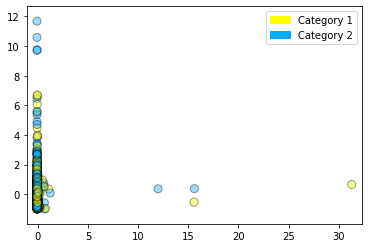

KMeans(n_clusters=3)

39520316.023106106


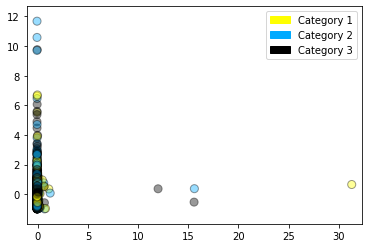

KMeans(n_clusters=4)

22232963.12248637


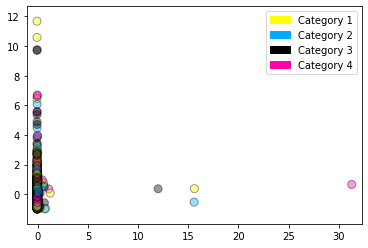

KMeans(n_clusters=5)

14229786.25202715


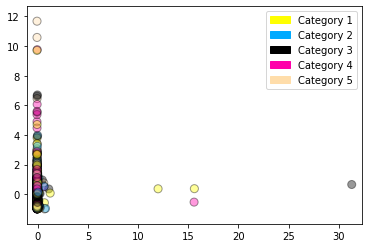

Text(0.5, 1.0, 'Elbow curve')

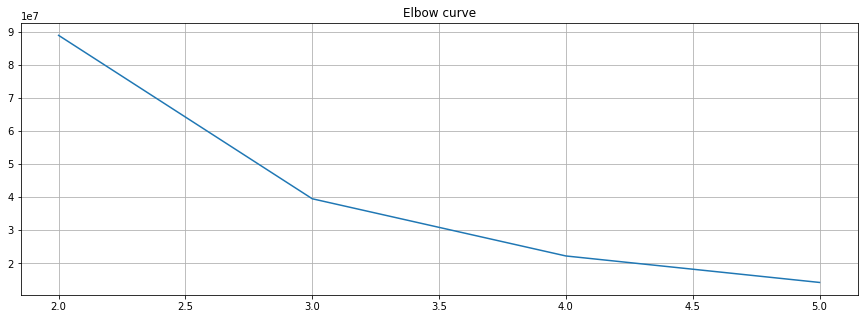

In [24]:
from sklearn.cluster import KMeans
from utils.visual import plot_labelled_scatter
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
for k in range(2,6):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_prepared)
    print(kmeans.inertia_)
    distortions.append(kmeans.inertia_)
    plot_labelled_scatter(df_prepared, kmeans.labels_, 
                          [ "Category " + str(i) for i in list(range(1,k+1)) ] )

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 6), distortions)
plt.grid(True)
plt.title('Elbow curve')

## Use Cluster = 3

KMeans(n_clusters=3)

39521393.40458184


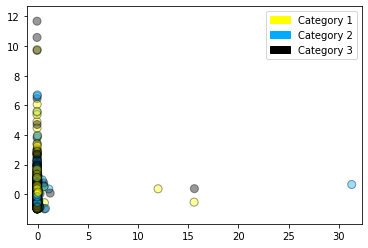

In [25]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_prepared)
print(kmeans.inertia_)
distortions.append(kmeans.inertia_)
plot_labelled_scatter(df_prepared, kmeans.labels_, 
                      [ "Category " + str(i) for i in list(range(1,4)) ] )

In [26]:
df_analysis['Category'] = kmeans.labels_
for i in range(0,3):
    display(len(df_analysis[df_analysis['Category'] == i]))
    display(df_analysis[df_analysis['Category'] == i])

541

,Stock Symbol,Revenue,EPS,Volume,Market Cap,Average Vol. (3m),Beta,1-Year Change,Shares Outstanding,PE,Yield,Category
1,GM,139640000000.0,8.65,9857370.0,70870000000.0,16140363.0,1.3,65.6%,1451723812.0,5.65,3.530,0
7,INTC,77620000000.0,4.5,13276862.0,217090000000.0,21726424.0,0.6,6.19%,4057000000.0,11.95,8.405,0
8,MSFT,168090000000.0,8.06,14353744.0,2260000000000.0,22272498.0,0.78,38.58%,7514891248.0,37.39,3.450,0
17,FDX,83960000000.0,18.42,1516487.0,70790000000.0,2240464.0,1.23,20.4%,266190927.0,14.44,4.155,0
18,GIS,18130000000.0,3.78,2270811.0,35020000000.0,3292909.0,0.54,-8.26%,606277260.0,15.29,12.070,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4553,GPMT,206.76M,0.6,168310.0,753.9M,325902.0,1.57,110.2%,54789465.0,22.85,14.170,0
4559,KTB,2390000000.0,3.29,308934.0,3130000000.0,523322.0,-,134.66%,57663976.0,16.50,12.105,0
4562,GATX,1230000000.0,3.03,134879.0,3240000000.0,148947.0,0.99,35.95%,35471796.0,29.80,9.095,0
4567,JHG,2610000000.0,3.34,395768.0,7340000000.0,985301.0,1.43,110.02%,169303797.0,13.00,19.000,0


545

,Stock Symbol,Revenue,EPS,Volume,Market Cap,Average Vol. (3m),Beta,1-Year Change,Shares Outstanding,PE,Yield,Category
28,ORCL,40480000000.0,4.57,8337982.0,251140000000.0,10736180.0,0.79,57.62%,2792000000.0,19.68,5.875,1
32,ODP,9480000000.0,0.77,253330.0,2430000000.0,321534.0,2.15,97.74%,53328218.0,60.01,2.705,1
51,QCOM,32580000000.0,8.01,5477276.0,165200000000.0,6939674.0,1.32,24.22%,1128000000.0,18.12,7.725,1
58,STLD,12940000000.0,6.71,1236449.0,13630000000.0,2059422.0,1.45,120.29%,204113883.0,10.05,8.575,1
69,SPAR,816.92M,1.52,108349.0,1550000000.0,173831.0,1.53,118.64%,35350265.0,29.57,1.035,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4519,WSR,119.4M,0.2,480185.0,454.77M,516241.0,1.44,49.92%,46310113.0,48.94,68.910,1
4522,WNC,1600000000.0,0.47,239125.0,770.14M,354365.0,1.83,30.68%,50009288.0,32.59,7.680,1
4528,RMAX,293.07M,0.59,75230.0,635.68M,118762.0,1.49,-3.36%,18891019.0,56.58,9.590,1
4564,WH,1340000000.0,1.19,523058.0,6660000000.0,561519.0,1.79,36.63%,93523120.0,59.71,3.960,1


536

,Stock Symbol,Revenue,EPS,Volume,Market Cap,Average Vol. (3m),Beta,1-Year Change,Shares Outstanding,PE,Yield,Category
2,CVX,116310000000.0,1.86,9004216.0,188540000000.0,9921064.0,1.3,18.49%,1933911944.0,52.34,20.280,2
3,C,41430000000.0,9.63,13645145.0,144250000000.0,19743259.0,1.91,38.19%,2026785183.0,7.39,12.605,2
4,BAC,46640000000.0,2.99,41758807.0,345430000000.0,46868294.0,1.56,59.98%,8414903881.0,13.74,8.535,2
6,CAT,45890000000.0,7.83,2508364.0,115170000000.0,3776196.0,0.9,43.34%,547471467.0,26.88,8.425,2
10,F,136430000000.0,0.85,41411707.0,51490000000.0,63301568.0,1.13,89%,3994764392.0,15.23,6.820,2
...,...,...,...,...,...,...,...,...,...,...,...,...
4536,CCS,3830000000.0,10.67,178791.0,2430000000.0,497230.0,1.97,90.34%,33760940.0,6.63,0.865,2
4539,DEA,259.94M,0.26,558400.0,1820000000.0,645063.0,0.43,-9.84%,83870350.0,83.97,15.940,2
4544,CHCT,83.54M,0.86,69728.0,1160000000.0,90108.0,0.46,4.58%,23444275.0,57.68,13.725,2
4558,ACA,1900000000.0,1.61,193188.0,2480000000.0,245311.0,-,6.95%,48400823.0,31.50,1.640,2
